# Setup

**Start the colab kernel with GPU**: Runtime -> Change runtime type -> GPU

## Install dependencies

In [ ]:
!git clone https://github.com/suinleelab/vit-shapley

In [ ]:
!pip uninstall -y torchtext torchaudio tensorflow arviz cxvpy
!pip install -r vit-shapley/requirements.txt 

# Load dependencies

In [3]:
# Add github repo to the python path.
import sys
sys.path.append("./vit-shapley")

In [4]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import numpy as np
import requests
import seaborn as sns
import torch
from tqdm import tqdm
from vit_shapley.config import config, dataset_ImageNette, dataset_MURA, dataset_Pet
from vit_shapley.datamodules.ImageNette_datamodule import ImageNetteDataModule
from vit_shapley.datamodules.MURA_datamodule import MURADataModule
from vit_shapley.datamodules.Pet_datamodule import PetDataModule
from vit_shapley.modules.explainer import Explainer
from vit_shapley.modules.surrogate import Surrogate


def download_file(url, path):
  # Streaming, so we can iterate over the response.
  response = requests.get(url, stream=True)
  total_size_in_bytes= int(response.headers.get('content-length', 0))
  block_size = 1024 #1 Kibibyte
  progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
  with open(path, 'wb') as file:
      for data in response.iter_content(block_size):
          progress_bar.update(len(data))
          file.write(data)
  progress_bar.close()
  if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
      print("ERROR, something went wrong") 

def get_backbone_config(dataset_name):
  if dataset_name == "ImageNette":
      backbone_type_config_dict_ = OrderedDict(
          {
              "vit_base_patch16_224": {
                  "surrogate_path": "https://aimslab.cs.washington.edu/vitshapley/checkpoints/ImageNette_vit_base_patch16_224_surrogate_3i6zzjnp.ckpt",
                  "explainer_path": "https://aimslab.cs.washington.edu/vitshapley/checkpoints/ImageNette_vit_base_patch16_224_explainer_3ty85eft.ckpt",
              },
          }
      )
  elif dataset_name == "MURA":
      backbone_type_config_dict_ = OrderedDict(
          {
              "vit_base_patch16_224": {
                  "surrogate_path": "https://aimslab.cs.washington.edu/vitshapley/checkpoints/MURA_vit_base_patch16_224_surrogate_22ompjqu.ckpt",
                  "explainer_path": "https://aimslab.cs.washington.edu/vitshapley/checkpoints/MURA_vit_base_patch16_224_explainer_1dmhcwej.ckpt",
              },
          }
      )

  elif dataset_name == "Pet":
      backbone_type_config_dict_ = OrderedDict(
          {
              "vit_base_patch16_224": {
                  "surrogate_path": "https://aimslab.cs.washington.edu/vitshapley/checkpoints/Pet_vit_base_patch16_224_surrogate_146vf465.ckpt",
                  "explainer_path": "https://aimslab.cs.washington.edu/vitshapley/checkpoints/Pet_vit_base_patch16_224_explainer_2oq7lhr7.ckpt",
              },
          }
      )    
  return backbone_type_config_dict_

## Specifiy dataset name and backbone type

In [9]:
dataset_name="Pet"
backbone_to_use="vit_base_patch16_224"

_config=config()
if dataset_name=="ImageNette":
  _config.update(dataset_ImageNette())
elif dataset_name=="MURA":
  _config.update(dataset_MURA())
elif dataset_name=="Pet":
  _config.update(dataset_Pet())    

_config.update({'gpus_surrogate':[0,],
                'gpus_explainer':[0,]})

backbone_type_config = get_backbone_config(dataset_name)[backbone_to_use]

## Set up dataset

In [ ]:
dataset_parameters = {
    "dataset_location": _config["dataset_location"],
    "explanation_location_train": _config["explanation_location_train"],
    "explanation_mask_amount_train": _config["explanation_mask_amount_train"],
    "explanation_mask_ascending_train": _config["explanation_mask_ascending_train"],
    "explanation_location_val": _config["explanation_location_val"],
    "explanation_mask_amount_val": _config["explanation_mask_amount_val"],
    "explanation_mask_ascending_val": _config["explanation_mask_ascending_val"],
    "explanation_location_test": _config["explanation_location_test"],
    "explanation_mask_amount_test": _config["explanation_mask_amount_test"],
    "explanation_mask_ascending_test": _config["explanation_mask_ascending_test"],
    "transforms_train": _config["transforms_train"],
    "transforms_val": _config["transforms_val"],
    "transforms_test": _config["transforms_test"],
    "num_workers": _config["num_workers"],
    "per_gpu_batch_size": _config["per_gpu_batch_size"],
    "test_data_split": _config["test_data_split"],
}

if _config["datasets"] == "MURA":
    datamodule = MURADataModule(**dataset_parameters)
elif _config["datasets"] == "ImageNette":
    datamodule = ImageNetteDataModule(**dataset_parameters)
elif _config["datasets"] == "Pet":
    !mkdir pets
    download_file(
        "https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz",
        "pets_images.tar.gz",
    )
    download_file(
        "https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz",
        "pets_annotations.tar.gz",
    )
    !tar -xvf pets_images.tar.gz -C ./pets
    !tar -xvf pets_annotations.tar.gz -C ./pets
    dataset_parameters["dataset_location"] = "./pets"
    datamodule = PetDataModule(**dataset_parameters)
else:
    ValueError("Invalid 'datasets' configuration")

datamodule.set_test_dataset()

test_dataset = datamodule.test_dataset

dset = test_dataset

## Load model

In [12]:
download_file(backbone_type_config["surrogate_path"], "surrogate.ckpt")
surrogate = Surrogate(mask_location="pre-softmax",
                      backbone_type=backbone_to_use,
                      download_weight=False,
                      load_path="surrogate.ckpt",
                      target_type=_config["target_type"],
                      output_dim=_config["output_dim"],

                      target_model=None,
                      checkpoint_metric=None,
                      optim_type=None,
                      learning_rate=None,
                      weight_decay=None,
                      decay_power=None,
                      warmup_steps=None).to(_config["gpus_surrogate"][0])
                      
download_file(backbone_type_config["explainer_path"], "explainer.ckpt")
explainer = Explainer(normalization="additive",
                      normalization_class=_config["explainer_normalization_class"],
                      activation="tanh",
                      surrogate=surrogate,
                      link='sigmoid' if _config["output_dim"]==1 else 'softmax',
                      backbone_type=backbone_to_use,
                      download_weight=False,
                      residual=[],
                      load_path="explainer.ckpt",
                      target_type=_config["target_type"],
                      output_dim=_config["output_dim"],

                      explainer_head_num_attention_blocks=1,
                      explainer_head_include_cls=True,
                      explainer_head_num_mlp_layers=3,
                      explainer_head_mlp_layer_ratio=4,
                      explainer_norm=_config["explainer_norm"],

                      efficiency_lambda=_config["explainer_efficiency_lambda"],
                      efficiency_class_lambda=_config["explainer_efficiency_class_lambda"],
                      freeze_backbone="all",

                      checkpoint_metric=_config["checkpoint_metric"],
                      optim_type=_config["optim_type"],
                      learning_rate=_config["learning_rate"],
                      weight_decay=_config["weight_decay"],
                      decay_power=_config["decay_power"],
                      warmup_steps=_config["warmup_steps"]).to(_config["gpus_explainer"][0])                          

100%|██████████| 1.37G/1.37G [01:15<00:00, 18.2MiB/s]


In [13]:
label_dict={}

label_dict["ImageNette"]=['Cassette player', 
                          'Garbage truck', 
                          'Tench', 
                          'English springer', 
                          'Church', 
                          'Parachute', 
                          'French horn', 
                          'Chain saw', 
                          'Golf ball', 
                          'Gas pump']
label_dict["MURA"]=["Normal", "Abnormal"]


label_dict["Pet"]=['Abyssinian',
                    'American Bulldog',
                    'American Pit Bull Terrier',
                    'Basset Hound',
                    'Beagle',
                    'Bengal',
                    'Birman',
                    'Bombay',
                    'boxer',
                    'British Shorthair',
                    'Chihuahua',
                    'Egyptian Mau',
                    'English Cocker Spaniel',
                    'English Setter',
                    'German Shorthaired',
                    'Great Pyrenees',
                    'Havanese',
                    'Japanese Chin',
                    'Keeshond',
                    'Leonberger',
                    'Maine Coon',
                    'Miniature Pinscher',
                    'Newfoundland',
                    'Persian',
                    'Pomeranian',
                    'Pug',
                    'Ragdoll',
                    'Russian_Blue',
                    'Saint Bernard',
                    'Samoyed',
                    'Scottish Terrier',
                    'Shiba_inu',
                    'Siamese',
                    'Sphynx',
                    'Staffordshire Bull Terrier',
                    'Wheaten Terrier',
                    'Yorkshire Terrier']

In [44]:
def plot_figure(sample_idx_list, explainer):
    plt.rcParams["font.size"] = 8
    img_mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    img_std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis] 

    label_choice=[dset[sample_idx]["labels"] for sample_idx in sample_idx_list]
    class_list = label_choice #np.unique(label_choice).tolist()

    fig = plt.figure(figsize=(1.53*(len(["image"]+class_list)+0.2*len(["empty"])), 2*len(sample_idx_list)))
    box1 = gridspec.GridSpec(1, len(["image"]+["empty"]+class_list), 
                              wspace=0.06, 
                              hspace=0,
                              width_ratios=[1]+[0.2]+[1]*len(class_list))

    axd={}
    for idx1, plot_type in enumerate(["image"]+["empty"]+class_list):
        box2 = gridspec.GridSpecFromSubplotSpec(len(sample_idx_list),1, 
                                                subplot_spec=box1[idx1], wspace=0, hspace=0.2)
        for idx2, sample_idx in enumerate(sample_idx_list):
            box3 = gridspec.GridSpecFromSubplotSpec(1, 1,
                                                subplot_spec=box2[idx2], wspace=0, hspace=0)
            ax=plt.Subplot(fig, box3[0])
            fig.add_subplot(ax)
            axd[f"{sample_idx}_{plot_type}"]=ax

    for plot_key in axd.keys():
        if 'empty' in plot_key:
            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(0) 

    for idx1, sample_idx in enumerate(sample_idx_list):
        dataset_item=dset[sample_idx]

        image = dataset_item["images"]
        label = dataset_item["labels"]
        path = dataset_item["path"]

        image_unnormlized=((image.numpy() * img_std) + img_mean).transpose(1,2,0)
        assert image_unnormlized.min()>0 and image_unnormlized.max()<1
        image_unnormlized_scaled=(image_unnormlized-image_unnormlized.min())/(image_unnormlized.max()-image_unnormlized.min())
  
        for idx2, plot_type in enumerate(["image"]+["empty"]+class_list):
            if plot_type=="image":
                plot_key=f"{sample_idx}_image"
                axd[plot_key].imshow(image_unnormlized_scaled)
                if dataset_name=="ImageNette" or "Pet":
                    axd[plot_key].set_title(f"{label_dict[dataset_name][label_choice[idx1]]}", pad=7, zorder=10)
                else:
                    axd[plot_key].set_title(f"Abnormal", pad=7, zorder=10)
            elif plot_type=="empty":
                pass
            else:         
                plot_key=f"{sample_idx}_{plot_type}"
                explanation=explainer(image.unsqueeze(0).to(explainer.device))[0][0].T
                if len(explanation.shape)==2:
                    explanation_class=explanation[plot_type].detach().cpu().numpy()
                else:
                    explanation_class=explanation.detach().cpu().numpy()

                explanation_class_expanded=np.repeat(np.repeat(explanation_class.reshape(14, 14), 16, axis=0), 16, axis=1)
                explanation_class_expanded=torch.nn.functional.interpolate(torch.Tensor(explanation_class.reshape(1, 1, 14, 14)), 
                                                                          scale_factor=16, align_corners=False, mode='bilinear').numpy().reshape(224, 224)                                                        

                explanation_class_expanded_normalized=(0.5+(explanation_class_expanded)/np.max(np.abs(explanation_class_expanded))*0.5)
                explanation_class_expanded_heatmap=sns.color_palette("icefire", as_cmap=True)(explanation_class_expanded_normalized)#[:,:,:-1]
                explanation_class_expanded_heatmap[:,:,3]=0.6

                image_unnormlized_normalized=(image_unnormlized.sum(axis=2))/3
                image_unnormlized_normalized=cm.get_cmap('Greys', 1000)(1-image_unnormlized_normalized)#[:,:,:-1]
                image_unnormlized_normalized[:,:,3]=0.5

                axd[plot_key].imshow(image_unnormlized_normalized, alpha=0.85)
                axd[plot_key].imshow(explanation_class_expanded_heatmap, alpha=0.9)

                axd[plot_key].set_title(label_dict[dataset_name][plot_type])

            axd[plot_key].set_xticks([])
            axd[plot_key].set_yticks([])
            for axis in ['top','bottom','left','right']:
                axd[plot_key].spines[axis].set_linewidth(1)  
                    

<ipython-input-44-552f2bb7a6cb>:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  image_unnormlized_normalized=cm.get_cmap('Greys', 1000)(1-image_unnormlized_normalized)#[:,:,:-1]


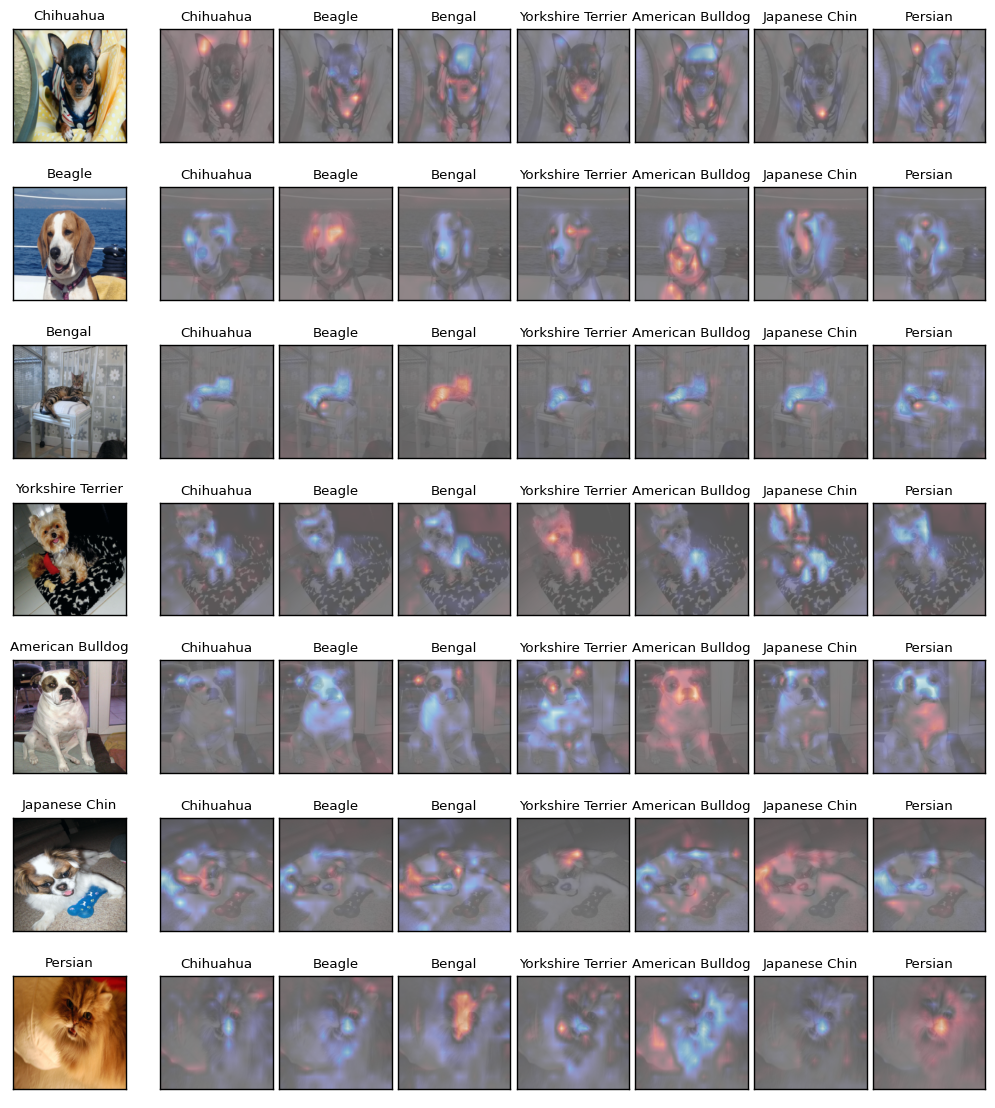

In [45]:
plot_figure(sample_idx_list=[7, 12, 13, 14, 15, 16, 17], explainer=explainer)